# COMP4318/5318 Assignment 2: Image Classification

### Group number: ...  , SID1: ... , SID2: ..., SID3: ... 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [337]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# Model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# FCNN and CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


import warnings




## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [338]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

In [339]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


In [340]:
# flatten the labels
y_train_flat = y_train.flatten()
label_counts = pd.Series(y_train_flat).value_counts().sort_index()
print(label_counts)

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64


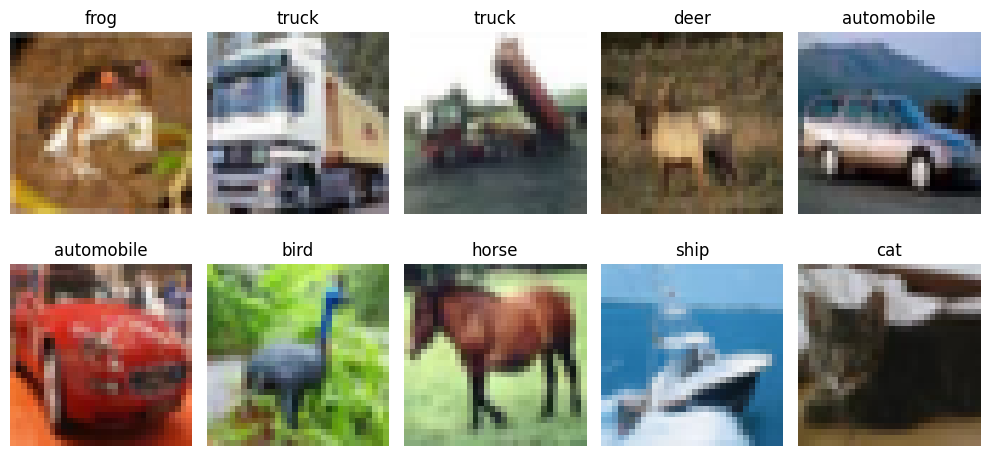

In [341]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    # Handle both (50000, 1) and (50000,) cases
    label_index = y_train[i] if np.ndim(y_train) == 1 else y_train[i][0]
    plt.title(class_names[label_index])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [342]:
from sklearn.model_selection import train_test_split

y_train = y_train.flatten()
y_test = y_test.flatten()

# Normalize pixel values for all models 
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# One-hot encode labels for Neural Networks 
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Flatten images for classical models
X_train_flat = X_train_norm.reshape((X_train.shape[0], -1))
X_test_flat = X_test_norm.reshape((X_test.shape[0], -1))

# 5. Subsample for classical models to prevent overload
X_small, _, y_small, _ = train_test_split(
    X_train_flat, y_train, train_size=2000, stratify=y_train, random_state=42
)
X_test_small, _, y_test_small, _ = train_test_split(
    X_test_flat, y_test, train_size=400, stratify=y_test, random_state=42
)
# Normalize images for neural networks
X_small_norm = X_small.astype("float32") / 255.0
X_test_small_norm = X_test_small.astype("float32") / 255.0

scaler = StandardScaler()
X_small_scaled = scaler.fit_transform(X_small)
X_test_small_scaled = scaler.transform(X_test_small)

X_small_norm = X_train_norm[:2000]
y_small_cat = y_train_cat[:2000]
X_test_small_norm = X_test_norm[:400]
y_test_small_cat = y_test_cat[:400]

print("Reduced classical training shape:", X_small.shape)
print("Reduced classical test shape:", X_test_small.shape)

Reduced classical training shape: (2000, 3072)
Reduced classical test shape: (400, 3072)


In [343]:
X_small_norm.shape

(2000, 32, 32, 3)

In [344]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

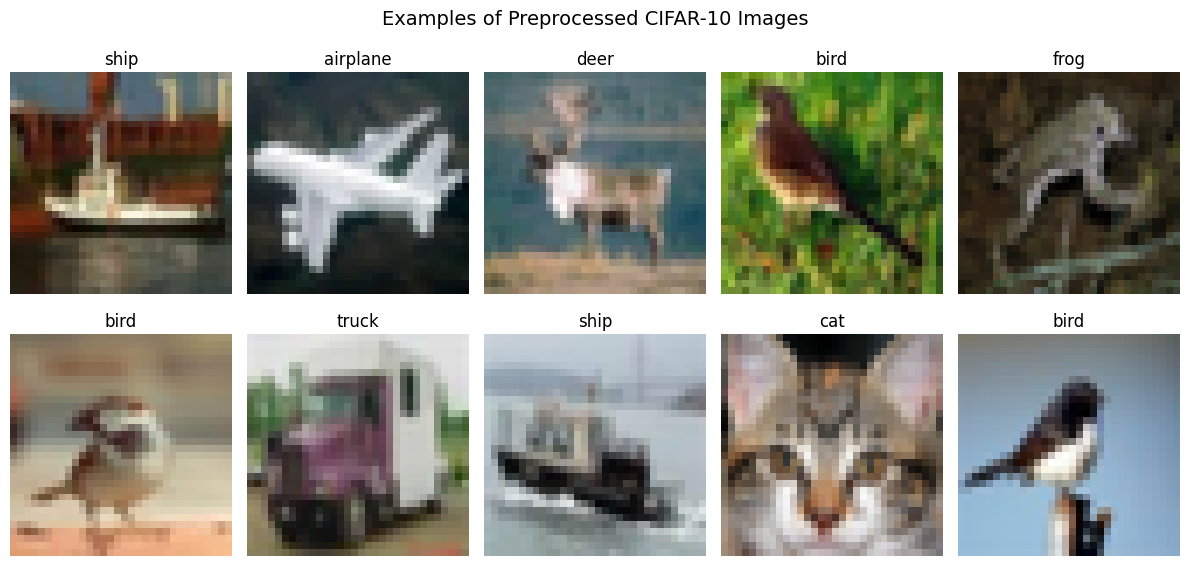

In [345]:
# Based on https://www.cs.toronto.edu/~kriz/cifar.html
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Randomly choose 10 samples
indices = np.random.choice(len(X_train), 10, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(class_names[y_train_flat[idx]])
    plt.axis('off')
plt.suptitle("Examples of Preprocessed CIFAR-10 Images", fontsize=14)
plt.tight_layout()
plt.show()

In [346]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.callbacks import EarlyStopping

# def build_mlp(hidden_units=[512, 256], dropout=0.5, lr=0.001):
#     model = Sequential()
#     model.add(Flatten(input_shape=(32,32,3)))
#     for units in hidden_units:
#         model.add(Dense(units, activation='relu'))
#         model.add(Dropout(dropout))
#     model.add(Dense(10, activation='softmax'))

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Try different configurations
# configs = [
#     {'hidden_units':[256,128], 'dropout':0.3},
#     {'hidden_units':[512,256], 'dropout':0.5},
# ]

# for cfg in configs:
#     print(f"Testing config: {cfg}")
#     mlp = build_mlp(hidden_units=cfg['hidden_units'], dropout=cfg['dropout'])
#     mlp.fit(X_train_norm, y_train_cat,
#             epochs=10,
#             batch_size=128,
#             validation_split=0.2,
#             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
#             verbose=1)
#     val_loss, val_acc = mlp.evaluate(X_test_norm, y_test_cat)
#     print("Test Accuracy:", val_acc)

In [347]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# def build_cnn(num_filters=[32,64], dense_units=128, dropout=0.5):
#     model = Sequential()
#     model.add(Conv2D(num_filters[0], (3,3), activation='relu', input_shape=(32,32,3)))
#     model.add(MaxPooling2D((2,2)))
#     model.add(Conv2D(num_filters[1], (3,3), activation='relu'))
#     model.add(MaxPooling2D((2,2)))
#     model.add(Flatten())
#     model.add(Dense(dense_units, activation='relu'))
#     model.add(Dropout(dropout))
#     model.add(Dense(10, activation='softmax'))

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Configurations to try
# cnn_configs = [
#     {'num_filters':[32,64], 'dense_units':128, 'dropout':0.5},
#     {'num_filters':[64,128], 'dense_units':256, 'dropout':0.3},
# ]

# for cfg in cnn_configs:
#     print(f"Testing config: {cfg}")
#     cnn = build_cnn(**cfg)
#     cnn.fit(X_train_norm, y_train_cat,
#             epochs=10,
#             batch_size=128,
#             validation_split=0.2,
#             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
#             verbose=1)
#     val_loss, val_acc = cnn.evaluate(X_test_norm, y_test_cat)
#     print("Test Accuracy:", val_acc) 

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [348]:
# Classical models
log_reg = LogisticRegression() 
svm = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
adb = AdaBoostClassifier(algorithm='SAMME')
gb = GradientBoostingClassifier()
bag = BaggingClassifier()
nb = GaussianNB()


### Fully connected neural network

In [349]:
fcnn = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])
fcnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fcnn.fit(X_small_norm, y_small_cat, epochs=10, batch_size=64, validation_split=0.1)
acc_fcnn = fcnn.evaluate(X_test_small_norm, y_test_small_cat, verbose=0)[1]
print("FCNN test accuracy:", acc_fcnn)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1170 - loss: 2.8523 - val_accuracy: 0.1200 - val_loss: 2.2726
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1606 - loss: 2.2647 - val_accuracy: 0.2150 - val_loss: 2.1460
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2073 - loss: 2.1399 - val_accuracy: 0.2700 - val_loss: 2.0676
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2082 - loss: 2.0807 - val_accuracy: 0.2200 - val_loss: 2.1008
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2354 - loss: 2.0482 - val_accuracy: 0.2800 - val_loss: 2.0487
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2426 - loss: 2.0093 - val_accuracy: 0.2300 - val_loss: 2.0339
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2601 - loss: 1.9691 - val_accuracy: 0.2800 - val_loss: 2.0555
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2926 - loss: 1.9698 - val_accuracy: 0.2550 - val_loss:

### Convolutional neural network

In [350]:
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_small_norm, y_small_cat, epochs=10, batch_size=64, validation_split=0.1)
acc_cnn = cnn.evaluate(X_test_small_norm, y_test_small_cat, verbose=0)[1]
print("CNN test accuracy:", acc_cnn)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1228 - loss: 2.3211 - val_accuracy: 0.0600 - val_loss: 2.2856
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1799 - loss: 2.1654 - val_accuracy: 0.1700 - val_loss: 2.1953
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2314 - loss: 2.0091 - val_accuracy: 0.2850 - val_loss: 2.1093
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2992 - loss: 1.9772 - val_accuracy: 0.3450 - val_loss: 1.9091
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3328 - loss: 1.8179 - val_accuracy: 0.3300 - val_loss: 1.9049
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3706 - loss: 1.7053 - val_accuracy: 0.3750 - val_loss: 1.7402
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4186 - loss: 1.5911 - val_accuracy: 0.4000 - val_loss: 1.6496
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4439 - loss: 1.5552 - val_accuracy: 0.4200 - val_lo

In [351]:

# Define base models
models = {
    "Logistic Regression": log_reg,
    "SVM": svm,
    "Decision Tree": dt,
    "Random Forest": rf,
    "AdaBoost": adb,
    "Gradient Boosting": gb,
    "Bagging": bag,
    "Naive Bayes": nb
}

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [ ]:
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="The max_iter was reached which means the coef_ did not converge")

# Parameter grids
param_grids = {
    "Logistic Regression": {"model__C": [0.1, 1.0], "model__max_iter": [500, 1000]},
    "SVM": {"model__C": [0.1, 1, 10], "model__kernel": ["linear", "rbf"]},
    "Decision Tree": {"model__max_depth": [5, 10, 20, None], "model__min_samples_split": [2, 5, 10]},
    "Random Forest": {"model__n_estimators": [50, 100], "model__max_depth": [10, 20, None]},
    "AdaBoost": {"model__n_estimators": [50, 100], "model__learning_rate": [0.01, 0.1]},
    "Gradient Boosting": {
        "reduce__n_components": [50, 100],   # PCA reduction
        "model__n_estimators": [50, 100],
        "model__learning_rate": [0.01, 0.1],
        "model__max_depth": [1, 3]
    },
    "Bagging": {"model__n_estimators": [50, 100]},
    "Naive Bayes": {}
}

tuned_results = {}
best_models = {}

print("\n✅ Starting model tuning...\n")

# Loop through models
for name, model in models.items():
    print(f"🔹 Tuning {name} ...")

    # --- Step 1: Create pipeline ---
    if name in ["Logistic Regression", "SVM"]:
        pipe = Pipeline([
            ("model", model)
        ])
    elif name == "Gradient Boosting":
        pipe = Pipeline([
            ("reduce", PCA(n_components=0.95)),   # PCA for speed and dimension reduction
            ("model", model)
        ])
    else:
        pipe = Pipeline([
            ("model", model)
        ])

    # --- Step 2: Define GridSearchCV ---
    grid = param_grids[name]
    if len(grid) == 0:
        pipe.fit(X_small, y_small)
        acc = accuracy_score(y_test_small, pipe.predict(X_test_small))
        tuned_results[name] = acc
        best_models[name] = pipe
        print(f"✅ {name}: No tuning. Accuracy = {acc:.4f}")
        continue

    # --- Step 3: Run GridSearchCV ---
    search = GridSearchCV(pipe, grid, cv=10, n_jobs=-1, scoring="accuracy", verbose=0)
    search.fit(X_small, y_small)
    best_pipe = search.best_estimator_

    # --- Step 4: Evaluate ---
    test_acc = accuracy_score(y_test_small, best_pipe.predict(X_test_small))
    tuned_results[name] = test_acc
    best_models[name] = best_pipe

    print(f"✅ {name}: Best Params = {search.best_params_}, Accuracy = {test_acc:.4f}")

print("\n🎯 All models tuned successfully!")


✅ Starting model tuning...

🔹 Tuning Logistic Regression ...
✅ Logistic Regression: Best Params = {'model__C': 0.1, 'model__max_iter': 500}, Accuracy = 0.2475
🔹 Tuning SVM ...
✅ SVM: Best Params = {'model__C': 10, 'model__kernel': 'rbf'}, Accuracy = 0.4050
🔹 Tuning Decision Tree ...
✅ Decision Tree: Best Params = {'model__max_depth': 5, 'model__min_samples_split': 5}, Accuracy = 0.2700
🔹 Tuning Random Forest ...
✅ Random Forest: Best Params = {'model__max_depth': 10, 'model__n_estimators': 100}, Accuracy = 0.4075
🔹 Tuning AdaBoost ...
✅ AdaBoost: Best Params = {'model__learning_rate': 0.1, 'model__n_estimators': 100}, Accuracy = 0.2475
🔹 Tuning Gradient Boosting ...
✅ Gradient Boosting: Best Params = {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'reduce__n_components': 100}, Accuracy = 0.3675
🔹 Tuning Bagging ...
✅ Bagging: Best Params = {'model__n_estimators': 100}, Accuracy = 0.4025
🔹 Tuning Naive Bayes ...
✅ Naive Bayes: No tuning. Accuracy = 0.31

In [353]:
tuned_results['CNN'] = acc_cnn
tuned_results['MLP'] = acc_fcnn
results_df = pd.DataFrame(list(tuned_results.items()), columns=["Model", "Tuned Accuracy"])
print("\n🏁 Hyperparameter Tuning Summary:")
print(results_df)


🏁 Hyperparameter Tuning Summary:
                 Model  Tuned Accuracy
0  Logistic Regression          0.2475
1                  SVM          0.4050
2        Decision Tree          0.2700
3        Random Forest          0.4075
4             AdaBoost          0.2475
5    Gradient Boosting          0.3675
6              Bagging          0.4025
7          Naive Bayes          0.3150
8                  CNN          0.4525
9                  MLP          0.3000


### Fully connected neural network

### Convolutional neural network

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network